# Anticipez  les besoins en consommation de bâtiments
## Modélisation TotalGHGEmissions

## Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

In [3]:
data = pd.read_csv('data_cleaned.csv')

In [4]:
data.head()

,BuildingType,PrimaryPropertyType,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,SiteEnergyUse(kBtu),TotalGHGEmissions,SteamBool,GasBool
0,NonResidential,Hotel,DOWNTOWN,1926,1.0,11,0,83008,27.0,5758795.000,176.14,False,True
1,NonResidential,Other,DOWNTOWN,1926,1.0,8,0,102761,NaN,6298131.500,221.51,True,True
2,Multifamily MR (5-9),Mid-Rise Multifamily,DOWNTOWN,1910,1.0,6,1496,62216,1.0,4573777.000,151.12,True,True
3,NonResidential,Hotel,NORTHEAST,2001,1.0,6,30586,58006,84.0,3663534.500,90.01,False,True
4,NonResidential,Other,DOWNTOWN,1930,1.0,2,0,67224,NaN,1310236.625,9.13,False,False


In [5]:
data.shape

(2758, 13)

# Répartition des données

In [6]:
# Définition des targets
targets = ['TotalGHGEmissions', 'SiteEnergyUse(kBtu)']

# Suppression de la variable ENERGYSTARScore du dataset
ES_Score = 'ENERGYSTARScore'
X = data.drop(columns = targets)
X.drop(columns = ES_Score, inplace=True)

# y = data[targets[1]]
y = data[targets[0]]

In [7]:
X.shape

(2758, 10)

In [8]:
y.shape

(2758,)

In [9]:
X.dtypes

BuildingType               object
PrimaryPropertyType        object
Neighborhood               object
YearBuilt                   int64
NumberofBuildings         float64
NumberofFloors              int64
PropertyGFAParking          int64
PropertyGFABuilding(s)      int64
SteamBool                    bool
GasBool                      bool
dtype: object

## Train test split

In [10]:
# passage au log de la target pour comparaison des résultats
y_log = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1000) # 42 for linear bug 
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, train_size=0.8, random_state=1000) # 42 for linear bug 


## Standardisation
- Tri entre numeric et categoric =>  include= number OR include=object, bool
- définir les pipelines => num_pipeline (StandardScaler) & cat_pipeline (OneHotEncoder)
- injecter pipelines dans ColumnTransformer
- Pipeline avec ColumnTransformer + model

In [11]:
def prepocessor_pipe(X):
    """ Fonction de définition des Pipelines pour les variables catégoriques et numériques """
    
    ### Pipeline pour numeric features : Simple Imputer, StandardScaler
    num_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='mean')), # In case there is missing values
        ('scale', StandardScaler())
    ])

    # Pipeline pour categoric features : Simple Imputer, OneHoteEncoder, StandardScaler
    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')), # In case there is missing values
        ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False)),
        ('scale', StandardScaler())
    ])

    # ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ('num', num_pipeline, X.select_dtypes(include='number').columns),
        ('cat', cat_pipeline, X.select_dtypes(include=['object', 'bool']).columns)
    ])
    return preprocessor

preprocessor = prepocessor_pipe(X)

In [12]:
def model_pipe(preprocessor, regressor):
    """ Fonction de définition des modèles, afin d'utiliser le même pipeline de preprocessing pour chaque modèles """
    
    pipe = Pipeline(steps=[
        ('preproc', preprocessor),
        ('model', regressor)
    ])
    return pipe

In [13]:
# Initialisation des variables afin de pouvoir relancer le notebook sans overwritting
score = pd.DataFrame()
bestparams = pd.DataFrame()

## Dummy regression

In [14]:
from sklearn.dummy import DummyRegressor

pipe = model_pipe(preprocessor, DummyRegressor())

from sklearn import set_config

set_config(display='diagram')
display(pipe)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['YearBuilt', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFAParking', 'PropertyGFABuilding(s)'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'SteamBool',
       'GasBool'],
      dtype='object'))])),
                ('model', DummyRegressor())])

Baseline model score: -0.0042160827713138005


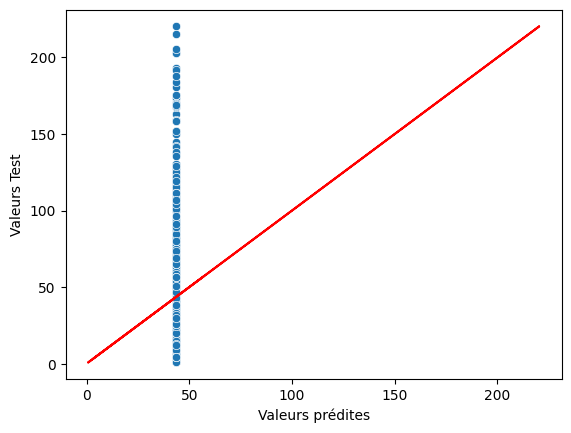

In [15]:
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print("Baseline model score: {}".format(pipe.score(X_test, y_test))) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

# Modèles
Premier test de modèles dans les versions par défaults :
- Linear Regression
- Ridge Regression
- Lasso Regression
- Elastic Net
- kNN
- SVR
- Neuron Network
- Random Forest
- Adaboost
- XGBoost

## Linear Regression

Model score: 0.5652546330068489


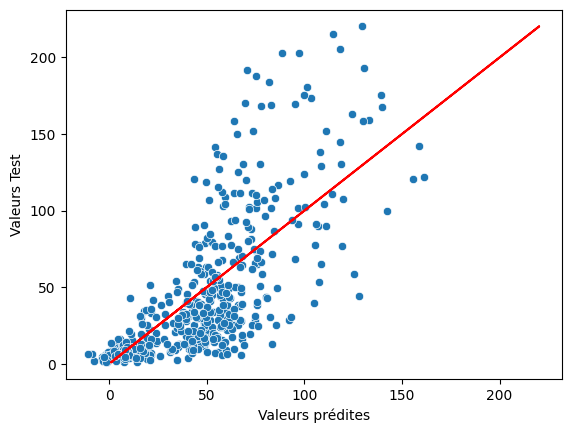

In [16]:
from sklearn.linear_model import LinearRegression

pipe = model_pipe(preprocessor, LinearRegression())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

print("Model score: {}".format(pipe.score(X_test, y_test))) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

Model score: 0.7092853719526121


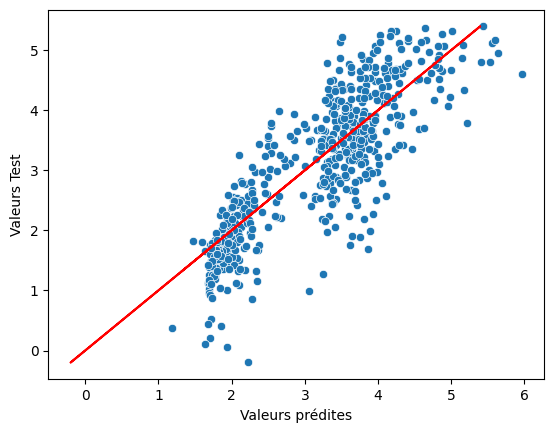

In [17]:
from sklearn.linear_model import LinearRegression

pipe = model_pipe(preprocessor, LinearRegression())

pipe.fit(X_train_log, y_train_log)

y_pred_log = pipe.predict(X_test_log)

print("Model score: {}".format(pipe.score(X_test_log, y_test_log))) # accuracy

sns.scatterplot(x=y_pred_log, y=y_test_log)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test_log, y_test_log, color='red')

## Linear Ridge

Model score: 0.565


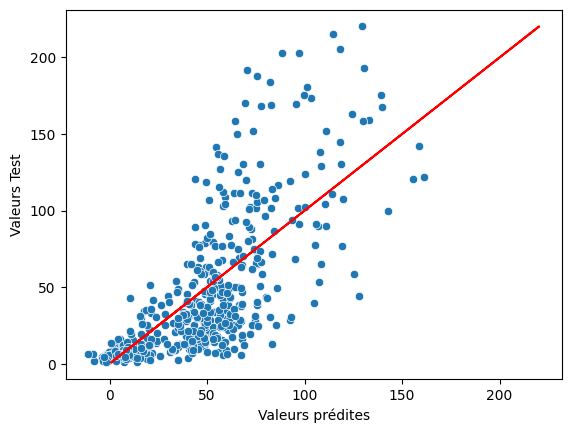

In [18]:
from sklearn.linear_model import Ridge

pipe = model_pipe(preprocessor, Ridge())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['Ridge Regression', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['Ridge Regression', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## Linear Lasso

Model score: 0.563


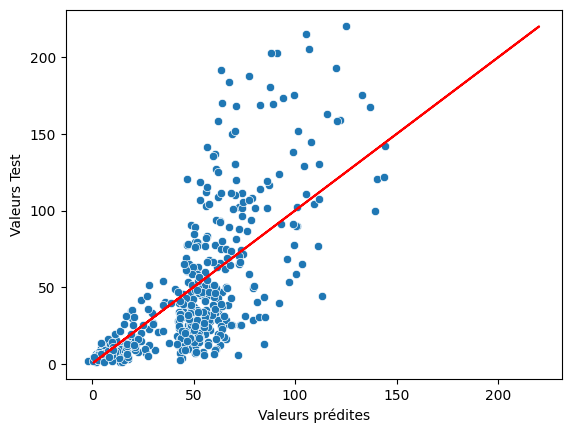

In [19]:
from sklearn.linear_model import Lasso

pipe = model_pipe(preprocessor, Lasso())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['Lasso Regression', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['Lasso Regression', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## Elastic Net

Model score: 0.52


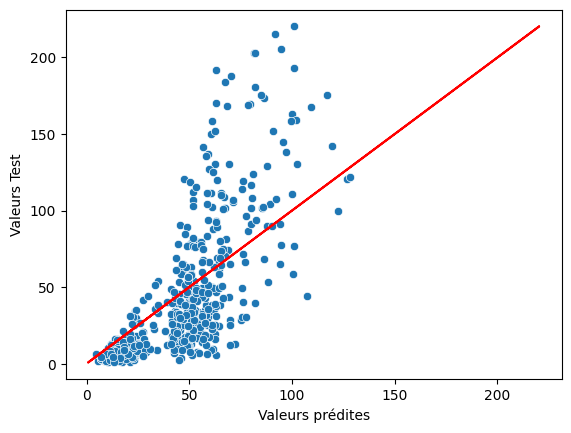

In [20]:
from sklearn.linear_model import ElasticNet

pipe = model_pipe(preprocessor, ElasticNet())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['Elastic Net', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['Elastic Net', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## kNN

Model score: 0.387


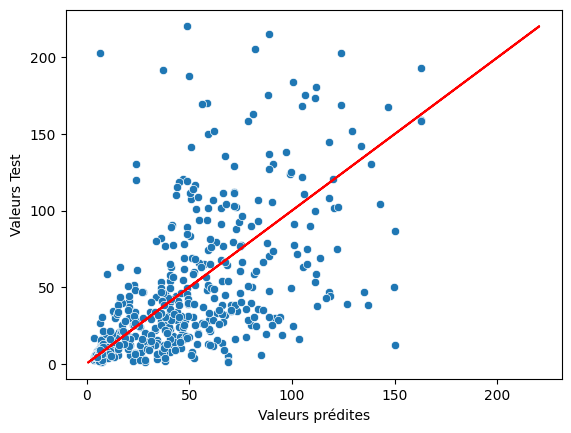

In [21]:
from sklearn.neighbors import KNeighborsRegressor

pipe = model_pipe(preprocessor, KNeighborsRegressor())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['kNN', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['kNN', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## SVR

Model score: 0.275


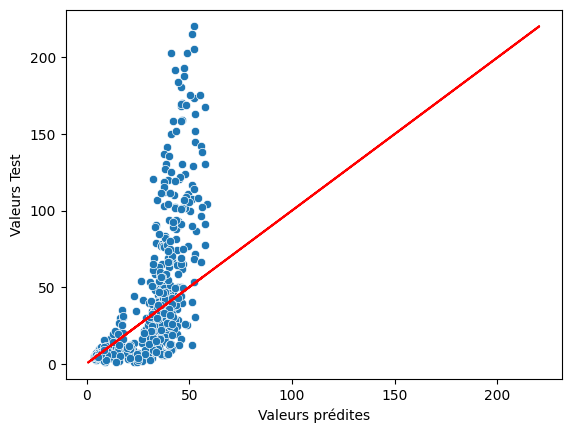

In [22]:
from sklearn.svm import SVR

pipe = model_pipe(preprocessor, SVR(kernel='rbf'))

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['SVR', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['SVR', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## Neuron Network

Model score: 0.574


C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


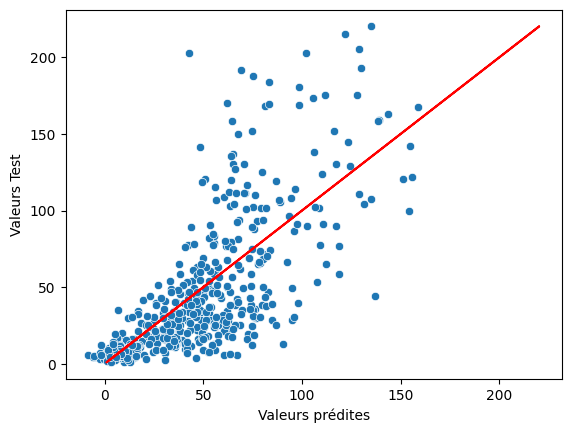

In [23]:
from sklearn.neural_network import MLPRegressor

pipe = model_pipe(preprocessor, MLPRegressor())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['Neuron Network', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['Neuron Network', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## Random Forest

Model score: 0.553


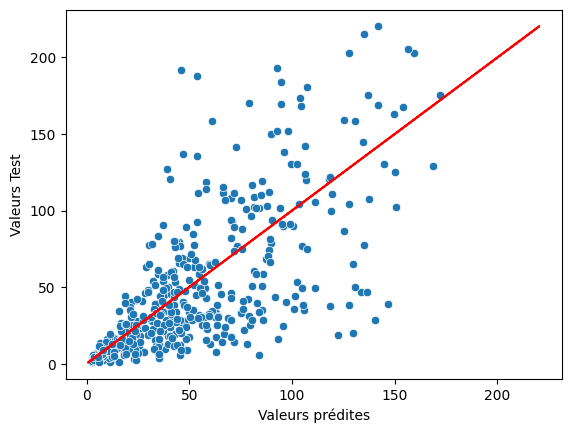

In [24]:
from sklearn.ensemble import RandomForestRegressor

pipe = model_pipe(preprocessor, RandomForestRegressor())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['Random Forest', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['Random Forest', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## Adaboost

Model score: 0.375


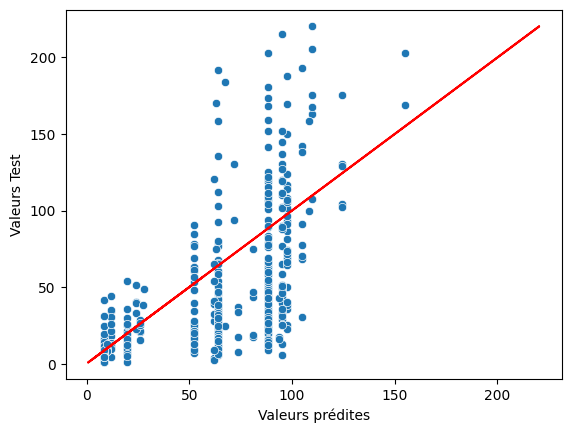

In [25]:
from sklearn.ensemble import AdaBoostRegressor
pipe = model_pipe(preprocessor, AdaBoostRegressor())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['Adaboost', 'R2'] = round(pipe.score(X_test, y_test), 3)

print("Model score: {}".format(score.loc['Adaboost', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## XGBoosting

Model score: 0.519


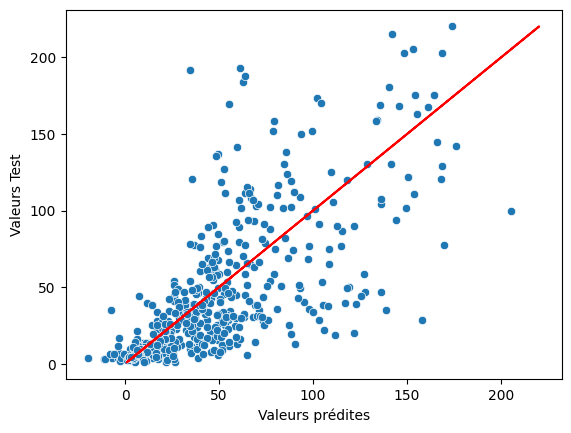

In [26]:
import xgboost as xg

pipe = model_pipe(preprocessor, xg.XGBRegressor())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
score.loc['XGBoost', 'R2'] = round(pipe.score(X_test, y_test),3)

print("Model score: {}".format(score.loc['XGBoost', 'R2'])) # accuracy

sns.scatterplot(x=y_pred, y=y_test)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test, y_test, color='red')

## Premiers résultats

In [27]:
score

,R2
Ridge Regression,0.565
Lasso Regression,0.563
Elastic Net,0.520
kNN,0.387
SVR,0.275
Neuron Network,0.574
Random Forest,0.553
Adaboost,0.375
XGBoost,0.519


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'SVR'),
  Text(1, 0, 'Adaboost'),
  Text(2, 0, 'kNN'),
  Text(3, 0, 'XGBoost'),
  Text(4, 0, 'Elastic Net'),
  Text(5, 0, 'Random Forest'),
  Text(6, 0, 'Lasso Regression'),
  Text(7, 0, 'Ridge Regression'),
  Text(8, 0, 'Neuron Network')])

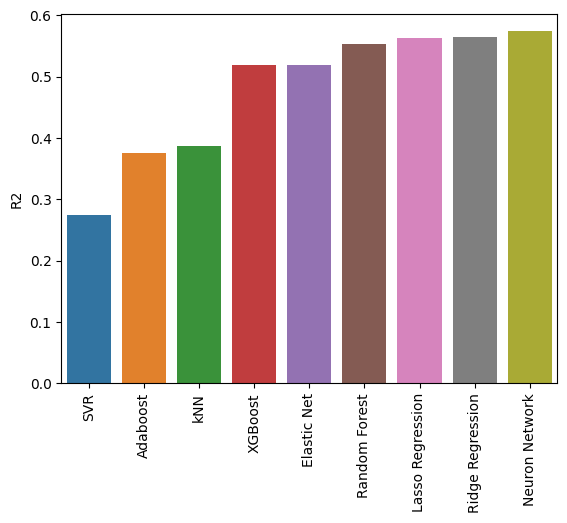

In [28]:
sns.barplot(data=score.sort_values(by='R2'), x=score.sort_values(by='R2').index, y='R2')
plt.xticks(rotation=90)

# GridSearchCV
Optimisation des modèles, et sauvegarde des scores

## Echelle d'origine

In [29]:
# Définition de la grille des hyperparamètres pour chaque modèle
param_grid_ridge = {'model__alpha': np.logspace(-3, 1, 5)}
param_grid_lasso = {'model__alpha': np.logspace(-3, 1, 5)}
param_grid_elastic = {'model__alpha': np.logspace(-3, 1, 5)}
param_grid_knn = {'model__n_neighbors':[3, 5, 7, 9, 11, 13, 15],
                  'model__weights': ['uniform', 'distance']}
param_grid_svr = {"model__kernel": ["linear", "rbf", "poly"]}
param_grid_neuron = {'model__activation': ['identity', 'logistic', 'relu']}
param_grid_rf = {'model__n_estimators': [10, 100, 1000],
                 'model__max_depth': [None, 10, 20],
                 'model__min_samples_split': [2, 5, 10]}
param_grid_ada = {'model__n_estimators': [50, 100, 200],
                  'model__learning_rate': [0.01, 0.1, 1],
                  'model__loss': ['linear', 'square', 'exponential']}
param_grid_xg = {'model__learning_rate': [0.01, 0.1, 0.5],
                 'model__max_depth': [3, 5, 7],
                 'model__min_child_weight': [1, 3, 5],
                 'model__subsample': [0.5, 0.7, 1],
                 'model__colsample_bytree': [0.5, 0.7, 1]}


# Création d'une liste de tuples pour pouvoir les itérer dans une boucle for
models = [
    ('Ridge Regression', model_pipe(preprocessor, Ridge()), param_grid_ridge),
    ('Lasso Regression', model_pipe(preprocessor, Lasso()), param_grid_lasso),
    ('Elastic Net', model_pipe(preprocessor, ElasticNet()), param_grid_elastic),
    ('kNN', model_pipe(preprocessor, KNeighborsRegressor()), param_grid_knn),
    ('SVR', model_pipe(preprocessor, SVR()), param_grid_svr),
    ('Neuron Network', model_pipe(preprocessor, MLPRegressor()), param_grid_neuron),
    ('Random Forest', model_pipe(preprocessor, RandomForestRegressor()), param_grid_rf),
    ('Adaboost', model_pipe(preprocessor, AdaBoostRegressor()), param_grid_ada),
    ('XGBoost', model_pipe(preprocessor, xg.XGBRegressor()), param_grid_xg)
     ]

# Définition de la cross-validation
cv_folds = KFold(n_splits=10, shuffle=True, random_state=1000)
CV_results = {}

# Iteration sur la liste des modèles pour effectuer la recherche des meilleurs hyperparamètres pour chacun
for name, model, param in models:
    print('GridSearchCV pour :', name)
    
    CV_results[name] = GridSearchCV(estimator=model, param_grid=param, scoring='r2', cv=cv_folds)
    CV_results[name].fit(X_train, y_train)
    
    # Stockage du score r2 test dans variable score et affichage
    score.loc[name, 'R2_cv'] = round(CV_results[name].score(X_test, y_test), 3)
    print(name, "best parameters:", CV_results[name].best_params_)
    print("{} R2 score: {:.3f}\n".format(name, CV_results[name].score(X_test, y_test)),)

GridSearchCV pour : Ridge Regression
Ridge Regression best parameters: {'model__alpha': 10.0}
Ridge Regression R2 score: 0.565

GridSearchCV pour : Lasso Regression


C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.204e+03, tolerance: 4.290e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.785e+04, tolerance: 4.225e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.324e+04, toleranc

Lasso Regression best parameters: {'model__alpha': 0.1}
Lasso Regression R2 score: 0.567

GridSearchCV pour : Elastic Net


C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.325e+05, tolerance: 4.251e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.275e+05, tolerance: 4.290e+02
  model = cd_fast.enet_coordinate_descent(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.159e+05, toleranc

Elastic Net best parameters: {'model__alpha': 0.1}
Elastic Net R2 score: 0.563

GridSearchCV pour : kNN
kNN best parameters: {'model__n_neighbors': 13, 'model__weights': 'distance'}
kNN R2 score: 0.438

GridSearchCV pour : SVR
SVR best parameters: {'model__kernel': 'linear'}
SVR R2 score: 0.556

GridSearchCV pour : Neuron Network


C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Neuron Network best parameters: {'model__activation': 'relu'}
Neuron Network R2 score: 0.565

GridSearchCV pour : Random Forest
Random Forest best parameters: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 1000}
Random Forest R2 score: 0.577

GridSearchCV pour : Adaboost
Adaboost best parameters: {'model__learning_rate': 0.01, 'model__loss': 'exponential', 'model__n_estimators': 50}
Adaboost R2 score: 0.506

GridSearchCV pour : XGBoost
XGBoost best parameters: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_child_weight': 1, 'model__subsample': 0.5}
XGBoost R2 score: 0.588



## Echelle log

In [30]:
# Version log
# Iteration sur la liste des modèles pour effectuer la recherche des meilleurs hyperparamètres pour chacun

CV_results_log = {}
for name, model, param in models:
    print('GridSearchCV pour :', name)
    
    CV_results_log[name] = GridSearchCV(estimator=model, param_grid=param, scoring='r2', cv=cv_folds)
    CV_results_log[name].fit(X_train_log, y_train_log)
    
    # Stockage du score r2 test dans variable score et affichage
    score.loc[name, 'R2_cv_log'] = round(CV_results_log[name].score(X_test_log, y_test_log), 3)
    print(name, "best parameters:", CV_results_log[name].best_params_)
    print("{} R2 score: {:.3f}\n".format(name, CV_results_log[name].score(X_test_log, y_test_log)),)

GridSearchCV pour : Ridge Regression
Ridge Regression best parameters: {'model__alpha': 10.0}
Ridge Regression R2 score: 0.709

GridSearchCV pour : Lasso Regression
Lasso Regression best parameters: {'model__alpha': 0.01}
Lasso Regression R2 score: 0.706

GridSearchCV pour : Elastic Net
Elastic Net best parameters: {'model__alpha': 0.01}
Elastic Net R2 score: 0.708

GridSearchCV pour : kNN
kNN best parameters: {'model__n_neighbors': 11, 'model__weights': 'distance'}
kNN R2 score: 0.619

GridSearchCV pour : SVR
SVR best parameters: {'model__kernel': 'rbf'}
SVR R2 score: 0.732

GridSearchCV pour : Neuron Network


C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Neuron Network best parameters: {'model__activation': 'logistic'}
Neuron Network R2 score: 0.742

GridSearchCV pour : Random Forest
Random Forest best parameters: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 1000}
Random Forest R2 score: 0.748

GridSearchCV pour : Adaboost
Adaboost best parameters: {'model__learning_rate': 0.1, 'model__loss': 'exponential', 'model__n_estimators': 50}
Adaboost R2 score: 0.651

GridSearchCV pour : XGBoost
XGBoost best parameters: {'model__colsample_bytree': 0.7, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_child_weight': 3, 'model__subsample': 0.7}
XGBoost R2 score: 0.776



# Interprétation

## Scores

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calcul des score RMSE et MAE
for name, model in CV_results.items():
    y_pred = model.best_estimator_.predict(X_test)
    score.loc[name, 'RMSE'] = round((mean_squared_error(y_test, y_pred) ** 0.5), 3)
    score.loc[name, 'MAE'] = round(mean_absolute_error(y_test, y_pred), 3)
    
# Calcul des score RMSE et MAE LOG
for name, model in CV_results_log.items():
    y_pred_log = model.best_estimator_.predict(X_test_log)
    score.loc[name, 'R2_log2lin'] = round(r2_score(np.exp(y_test_log), np.exp(y_pred_log)), 3)
    score.loc[name, 'RMSE_log2lin'] = round((mean_squared_error(np.exp(y_test_log), np.exp(y_pred_log)) ** 0.5), 3)
    score.loc[name, 'MAE_log2lin'] = round(mean_absolute_error(np.exp(y_test_log), np.exp(y_pred_log)), 3)

In [32]:
score

,R2,R2_cv,R2_cv_log,RMSE,MAE,R2_log2lin,RMSE_log2lin,MAE_log2lin
Ridge Regression,0.565,0.565,0.709,29.627,20.274,0.385,35.226,19.872
Lasso Regression,0.563,0.567,0.706,29.567,20.170,0.425,34.069,19.592
Elastic Net,0.520,0.563,0.708,29.690,20.196,0.409,34.533,19.690
kNN,0.387,0.438,0.619,33.667,21.816,0.408,34.552,20.764
SVR,0.275,0.556,0.732,29.947,18.700,0.573,29.346,17.560
Neuron Network,0.574,0.565,0.742,29.615,19.467,0.552,30.064,17.956
Random Forest,0.553,0.577,0.748,29.217,18.677,0.529,30.830,18.010
Adaboost,0.375,0.506,0.651,31.576,21.149,0.381,35.343,20.682
XGBoost,0.519,0.588,0.776,28.822,18.949,0.604,28.276,16.605


In [33]:
# Changement d'index pour faciliter les affichages
score.reset_index(inplace=True)
score.rename(columns={'index':'model'}, inplace=True)

### Comparaison Modèles et échelles

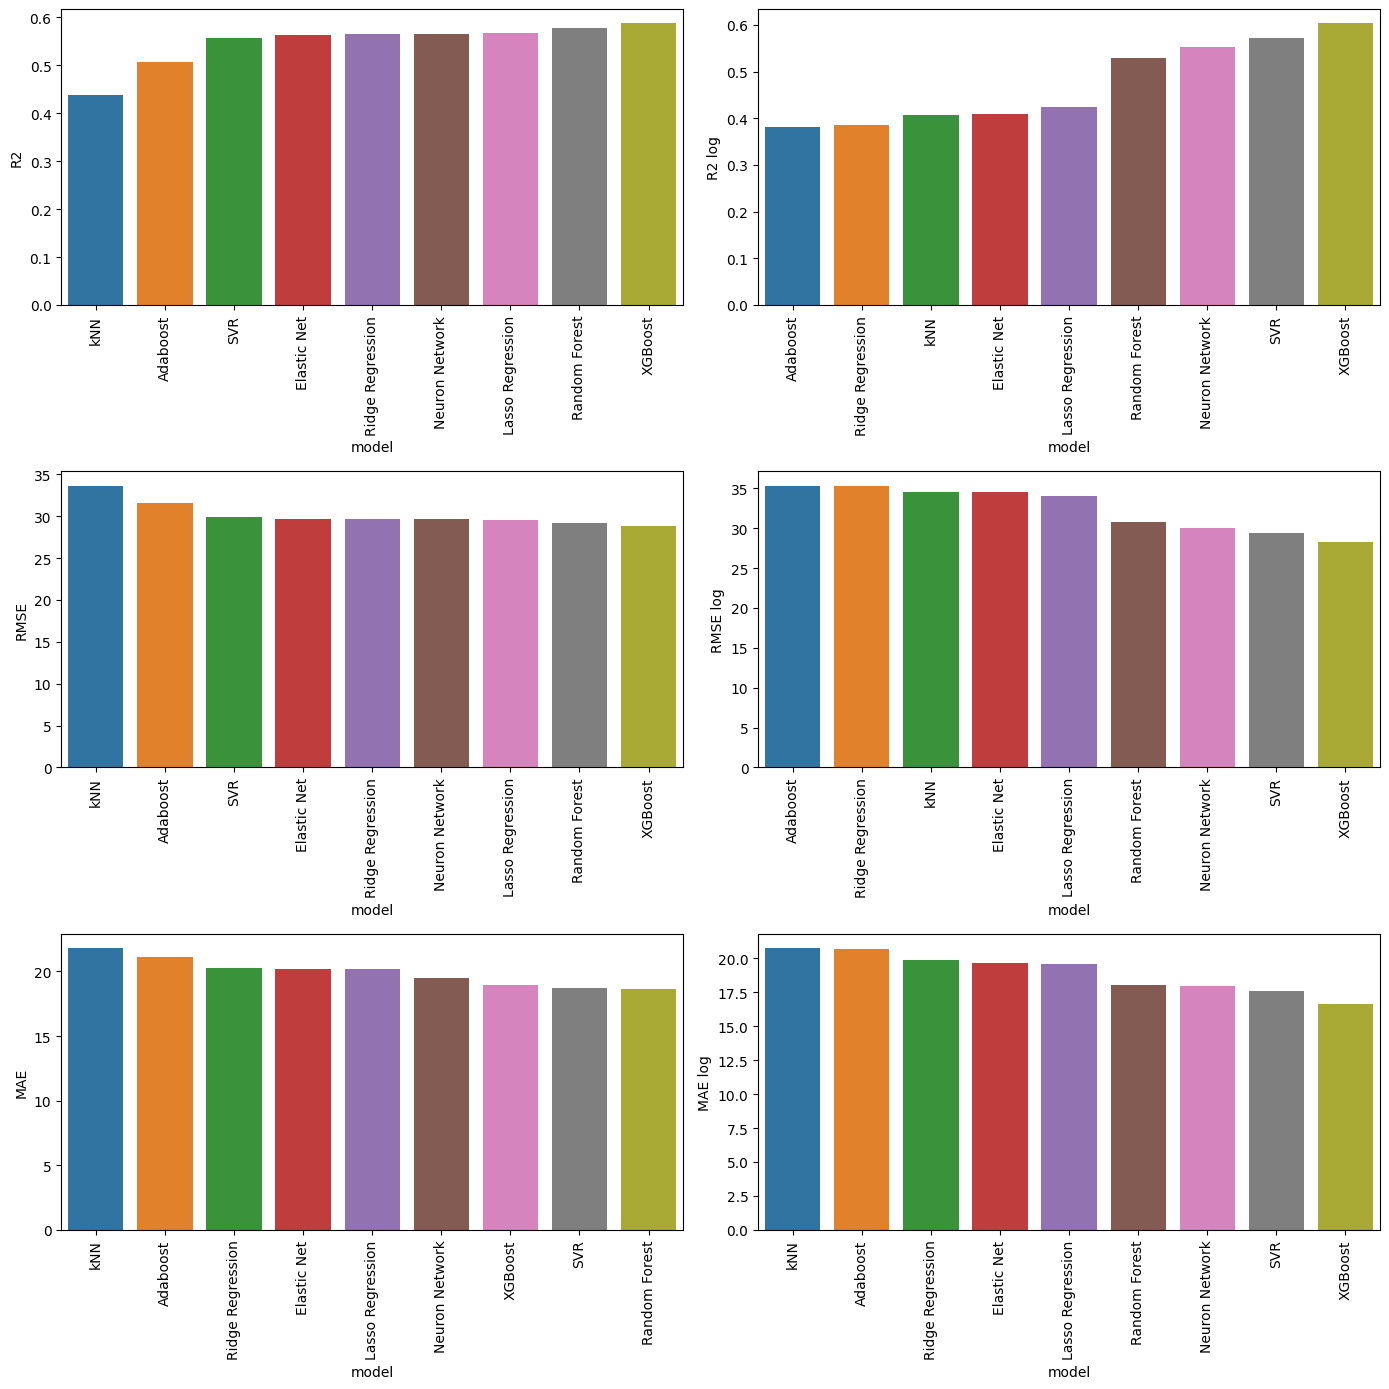

In [34]:
# Création de la figure et des sous-figures
fig, axs = plt.subplots(3, 2, figsize=(14, 14))

# Barplot pour le score R2
sns.barplot(data=score.sort_values(by='R2_cv'), x='model', y='R2_cv', ax=axs[0,0])
axs[0,0].set_ylabel('R2')
axs[0,0].set_xticklabels(axs[0,0].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le score R2_log
sns.barplot(data=score.sort_values(by='R2_log2lin'), x='model', y='R2_log2lin', ax=axs[0,1])
axs[0,1].set_ylabel('R2 log')
axs[0,1].set_xticklabels(axs[0,1].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le RMSE
sns.barplot(data=score.sort_values(by='RMSE', ascending=False), x='model', y='RMSE', ax=axs[1,0])
axs[1,0].set_ylabel('RMSE')
axs[1,0].set_xticklabels(axs[1,0].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le RMSE_log
sns.barplot(data=score.sort_values(by='RMSE_log2lin', ascending=False), x='model', y='RMSE_log2lin', ax=axs[1,1])
axs[1,1].set_ylabel('RMSE log')
axs[1,1].set_xticklabels(axs[1,1].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le MAE
sns.barplot(data=score.sort_values(by='MAE', ascending=False), x='model', y='MAE', ax=axs[2,0])
axs[2,0].set_ylabel('MAE')
axs[2,0].set_xticklabels(axs[2,0].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le MAE_log
sns.barplot(data=score.sort_values(by='MAE_log2lin', ascending=False), x='model', y='MAE_log2lin', ax=axs[2,1])
axs[2,1].set_ylabel('MAE log')
axs[2,1].set_xticklabels(axs[2,1].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Affichage de la figure
plt.tight_layout()
plt.show()

### Best model : XGBoost
### Comparaison des échelles pour XGBoost

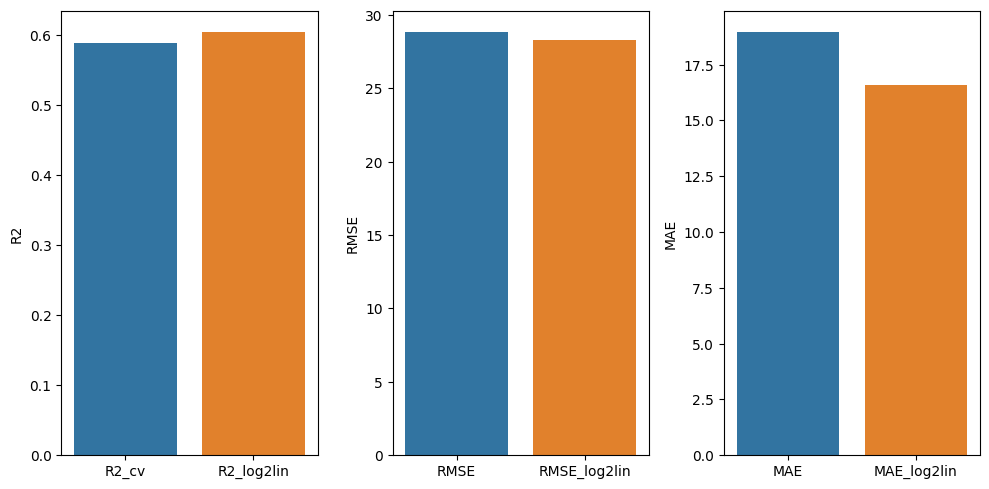

In [35]:

# Création de la figure et des sous-figures
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Barplot pour le score R2
sns.barplot(data=score.loc[score['model'] == 'XGBoost', ['R2_cv', 'R2_log2lin']], ax=axs[0])
axs[0].set_ylabel('R2')
# Barplot pour le RMSE
sns.barplot(data=score.loc[score['model'] == 'XGBoost', ['RMSE', 'RMSE_log2lin']], ax=axs[1])
axs[1].set_ylabel('RMSE')

# Barplot pour le MAE
sns.barplot(data=score.loc[score['model'] == 'XGBoost', ['MAE', 'MAE_log2lin']], ax=axs[2])
axs[2].set_ylabel('MAE')

# Affichage de la figure
plt.tight_layout()
plt.show()

In [36]:
print("Score R2 :", r2_score(y_test, y_pred))

Score R2 : 0.5883935995099073


In [37]:
print("Score R2_log2lin :", r2_score(np.exp(y_test_log), np.exp(y_pred_log)))

Score R2_log2lin : 0.6038475111605905


## Meilleur échelle : Log

Text(0.5, 1.0, 'Valeurs réelles vs Prédictions (logarithme)')

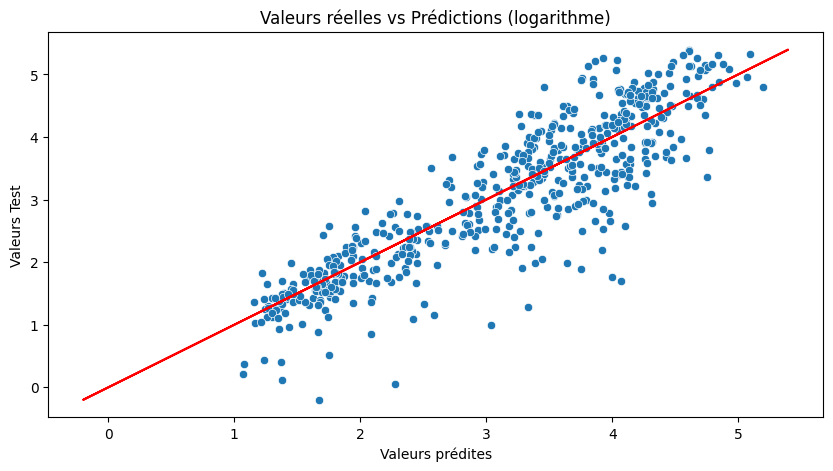

In [38]:
# Stockage du meilleur modèle dans best_model
best_model = CV_results_log['XGBoost'].best_estimator_
y_pred_log = best_model.predict(X_test_log)

fig = plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred_log, y=y_test_log)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_test_log, y_test_log, color='red')
plt.title('Valeurs réelles vs Prédictions (logarithme)')

#### Remise à l'échelle des valeurs

Text(0.5, 1.0, 'Valeurs réelles vs Prédictions')

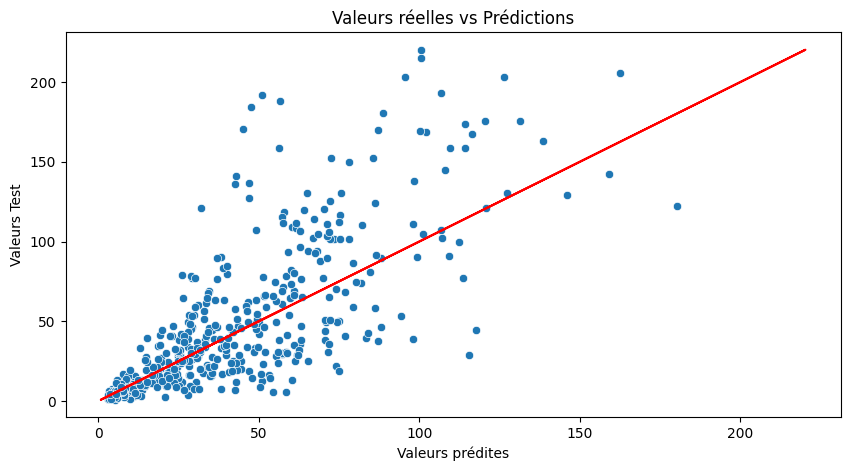

In [39]:
y_pred_log = best_model.predict(X_test_log)

fig = plt.figure(figsize=(10, 5))
sns.scatterplot(x=np.exp(y_pred_log), y=np.exp(y_test_log))
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(np.exp(y_test_log), np.exp(y_test_log), color='red')
plt.title('Valeurs réelles vs Prédictions')

## Features importance

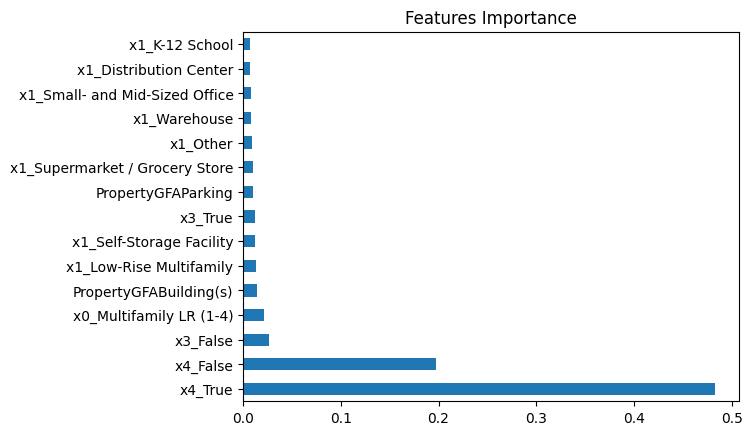

In [40]:
# Récupération des features après OneHotEncoder
num_feature_names = X.select_dtypes(include='number').columns.tolist()
cat_transformer = best_model.named_steps['preproc'].named_transformers_['cat']
cat_feature_names = cat_transformer.named_steps['one-hot'].get_feature_names_out().tolist()
feature_names = num_feature_names + cat_feature_names

# Affichage des scores d'importance des features
feature_importances = pd.Series(best_model.named_steps['model'].feature_importances_, index=feature_names)
feature_importances.nlargest(15).plot(kind='barh')
plt.title('Features Importance')
plt.show()

In [41]:
feature_importances.tail()

x2_SOUTHWEST    0.005986
x3_False        0.026955
x3_True         0.011949
x4_False        0.197685
x4_True         0.483425
dtype: float32

# Influence ENERGYSTARScore 

Relance du GridSearch **avec** la variable ENERGYSTARScore ajoutée au dataset

In [42]:
X = data.drop(columns = targets)
X.dtypes

BuildingType               object
PrimaryPropertyType        object
Neighborhood               object
YearBuilt                   int64
NumberofBuildings         float64
NumberofFloors              int64
PropertyGFAParking          int64
PropertyGFABuilding(s)      int64
ENERGYSTARScore           float64
SteamBool                    bool
GasBool                      bool
dtype: object

In [43]:
X_trainES, X_testES, y_trainES, y_testES = train_test_split(X, y_log, train_size=0.8, random_state=1000) # 42 for linear bug

preprocessor = prepocessor_pipe(X)

In [44]:
# Version log avec ES

# Création d'une liste de tuples pour pouvoir les itérer dans une boucle for
models = [
    ('Ridge Regression', model_pipe(preprocessor, Ridge()), param_grid_ridge),
    ('Lasso Regression', model_pipe(preprocessor, Lasso()), param_grid_lasso),
    ('Elastic Net', model_pipe(preprocessor, ElasticNet()), param_grid_elastic),
    ('kNN', model_pipe(preprocessor, KNeighborsRegressor()), param_grid_knn),
    ('SVR', model_pipe(preprocessor, SVR()), param_grid_svr),
    ('Neuron Network', model_pipe(preprocessor, MLPRegressor()), param_grid_neuron),
    ('Random Forest', model_pipe(preprocessor, RandomForestRegressor()), param_grid_rf),
    ('Adaboost', model_pipe(preprocessor, AdaBoostRegressor()), param_grid_ada),
    ('XGBoost', model_pipe(preprocessor, xg.XGBRegressor()), param_grid_xg)
     ]

CV_results_ES = {}

# Iteration sur la liste des modèles pour effectuer la recherche des meilleurs hyperparamètres pour chacun
for name, model, param in models:
    print('GridSearchCV pour :', name)
    
    CV_results_ES[name] = GridSearchCV(estimator=model, param_grid=param, scoring='r2', cv=cv_folds)
    CV_results_ES[name].fit(X_trainES, y_trainES)

    # Stockage du score r2 test dans variable score et affichage
    score.loc[score['model'] == name, 'R2_cv_log_ES'] = round(CV_results_ES[name].score(X_testES, y_testES), 3)
    print(name, "best parameters:", CV_results_ES[name].best_params_)
    print("{} R2 score: {:.3f}\n".format(name, CV_results_ES[name].score(X_testES, y_testES)),)

GridSearchCV pour : Ridge Regression
Ridge Regression best parameters: {'model__alpha': 10.0}
Ridge Regression R2 score: 0.742

GridSearchCV pour : Lasso Regression
Lasso Regression best parameters: {'model__alpha': 0.01}
Lasso Regression R2 score: 0.737

GridSearchCV pour : Elastic Net
Elastic Net best parameters: {'model__alpha': 0.01}
Elastic Net R2 score: 0.740

GridSearchCV pour : kNN
kNN best parameters: {'model__n_neighbors': 7, 'model__weights': 'distance'}
kNN R2 score: 0.615

GridSearchCV pour : SVR
SVR best parameters: {'model__kernel': 'rbf'}
SVR R2 score: 0.762

GridSearchCV pour : Neuron Network


C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\octav\anaconda3\lib\site-packages\sklearn\neural_network\_multi

Neuron Network best parameters: {'model__activation': 'logistic'}
Neuron Network R2 score: 0.773

GridSearchCV pour : Random Forest
Random Forest best parameters: {'model__max_depth': 10, 'model__min_samples_split': 10, 'model__n_estimators': 1000}
Random Forest R2 score: 0.779

GridSearchCV pour : Adaboost
Adaboost best parameters: {'model__learning_rate': 0.01, 'model__loss': 'exponential', 'model__n_estimators': 200}
Adaboost R2 score: 0.661

GridSearchCV pour : XGBoost
XGBoost best parameters: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__min_child_weight': 3, 'model__subsample': 0.7}
XGBoost R2 score: 0.803



# Interprétation

## Scores

In [56]:
# Calcul des score RMSE_ES et MAE_ES
for name, model in CV_results_ES.items():
    y_predES = model.best_estimator_.predict(X_testES)
    score.loc[score['model'] == name, 'R2_log2lin_ES'] = round(r2_score(np.exp(y_testES), np.exp(y_predES)), 3)
    score.loc[score['model'] == name, 'RMSE_ES'] = round((mean_squared_error(np.exp(y_testES), np.exp(y_predES)) ** 0.5), 3)
    score.loc[score['model'] == name, 'MAE_ES'] = round(mean_absolute_error(np.exp(y_testES), np.exp(y_predES)), 3)

In [57]:
score

,model,R2,R2_cv,R2_cv_log,RMSE,MAE,R2_log2lin,RMSE_log2lin,MAE_log2lin,R2_cv_log_ES,R2_log2lin_ES,RMSE_ES,MAE_ES
0,Ridge Regression,0.565,0.565,0.709,29.627,20.274,0.385,35.226,19.872,0.742,0.461,32.981,18.596
1,Lasso Regression,0.563,0.567,0.706,29.567,20.170,0.425,34.069,19.592,0.737,0.484,32.255,18.331
2,Elastic Net,0.520,0.563,0.708,29.690,20.196,0.409,34.533,19.690,0.740,0.476,32.522,18.443
3,kNN,0.387,0.438,0.619,33.667,21.816,0.408,34.552,20.764,0.615,0.413,34.426,20.474
4,SVR,0.275,0.556,0.732,29.947,18.700,0.573,29.346,17.560,0.762,0.589,28.814,17.053
5,Neuron Network,0.574,0.565,0.742,29.615,19.467,0.552,30.064,17.956,0.773,0.576,29.244,16.899
6,Random Forest,0.553,0.577,0.748,29.217,18.677,0.529,30.830,18.010,0.779,0.548,30.209,17.183
7,Adaboost,0.375,0.506,0.651,31.576,21.149,0.381,35.343,20.682,0.661,0.398,34.871,20.441
8,XGBoost,0.519,0.588,0.776,28.822,18.949,0.604,28.276,16.605,0.803,0.629,27.381,15.965


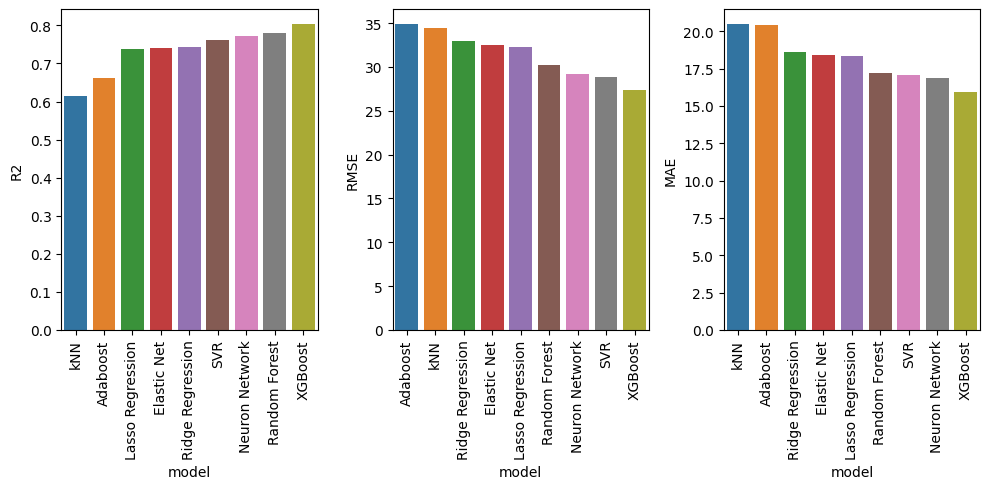

In [58]:

# Création de la figure et des sous-figures
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Barplot pour le score R2_ES
sns.barplot(data=score.sort_values(by='R2_cv_log_ES'), x='model', y='R2_cv_log_ES', ax=axs[0])
axs[0].set_ylabel('R2')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le RMSE_ES
sns.barplot(data=score.sort_values(by='RMSE_ES', ascending=False), x='model', y='RMSE_ES', ax=axs[1])
axs[1].set_ylabel('RMSE')
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Barplot pour le MAE_ES
sns.barplot(data=score.sort_values(by='MAE_ES', ascending=False), x='model', y='MAE_ES', ax=axs[2])
axs[2].set_ylabel('MAE')
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90) # rotation de 90 degrés

# Affichage de la figure
plt.tight_layout()
plt.show()

### Meilleur modèle : XGBoost

Text(0.5, 1.0, 'Valeurs réelles vs Prédictions (logarithme)')

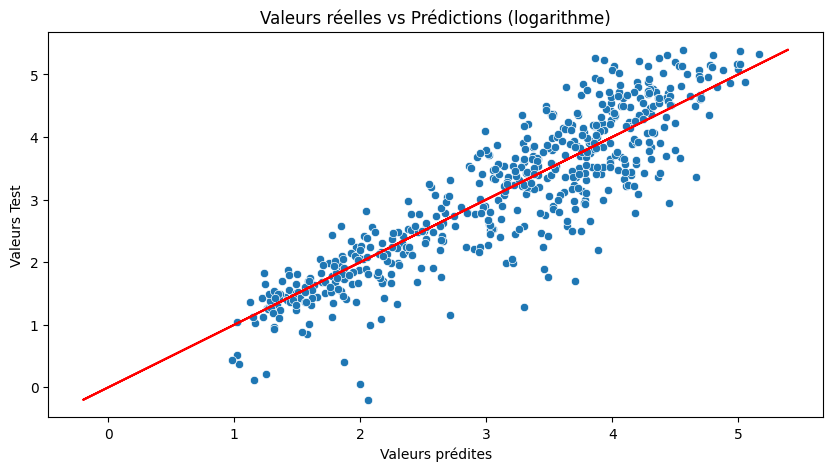

In [59]:
# Stockage du meilleur modèle dans best_model
best_model = CV_results_ES['XGBoost'].best_estimator_
y_predES = best_model.predict(X_testES)

fig = plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_predES, y=y_testES)
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(y_testES, y_testES, color='red')
plt.title('Valeurs réelles vs Prédictions (logarithme)')

#### Remise à l'échelle des valeurs

Text(0.5, 1.0, 'Valeurs réelles vs Prédictions')

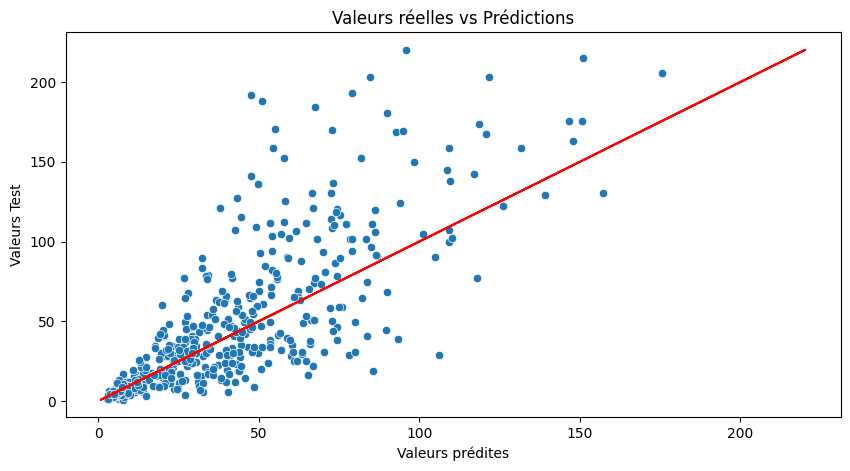

In [60]:
y_predES = best_model.predict(X_testES)

fig = plt.figure(figsize=(10, 5))
sns.scatterplot(x=np.exp(y_predES), y=np.exp(y_testES))
plt.ylabel('Valeurs Test')
plt.xlabel('Valeurs prédites')
plt.plot(np.exp(y_testES), np.exp(y_testES), color='red')
plt.title('Valeurs réelles vs Prédictions')

## Features importance

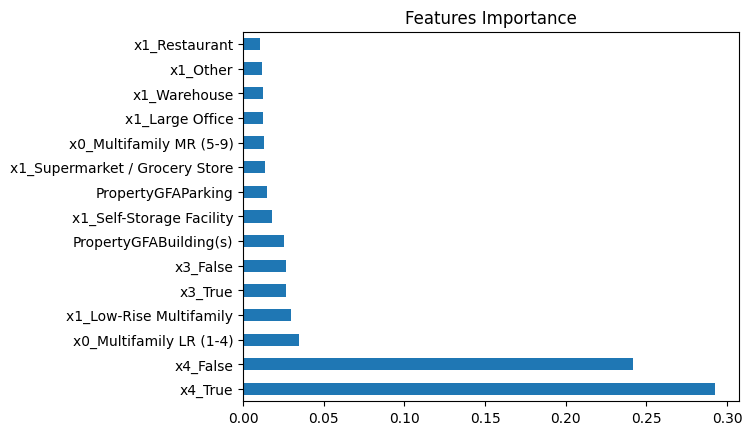

In [61]:

# Récupération des features après OneHotEncoder
num_feature_names = X.select_dtypes(include='number').columns.tolist()
cat_transformer = best_model.named_steps['preproc'].named_transformers_['cat']
cat_feature_names = cat_transformer.named_steps['one-hot'].get_feature_names_out().tolist()
feature_names = num_feature_names + cat_feature_names

# Affichage des scores d'importance des features
feature_importances = pd.Series(best_model.named_steps['model'].feature_importances_, index=feature_names)
feature_importances.nlargest(15).plot(kind='barh')
plt.title('Features Importance')
plt.show()

In [62]:
feature_importances['ENERGYSTARScore']

0.008360765

# Comparaison des modèles avec et sans ES

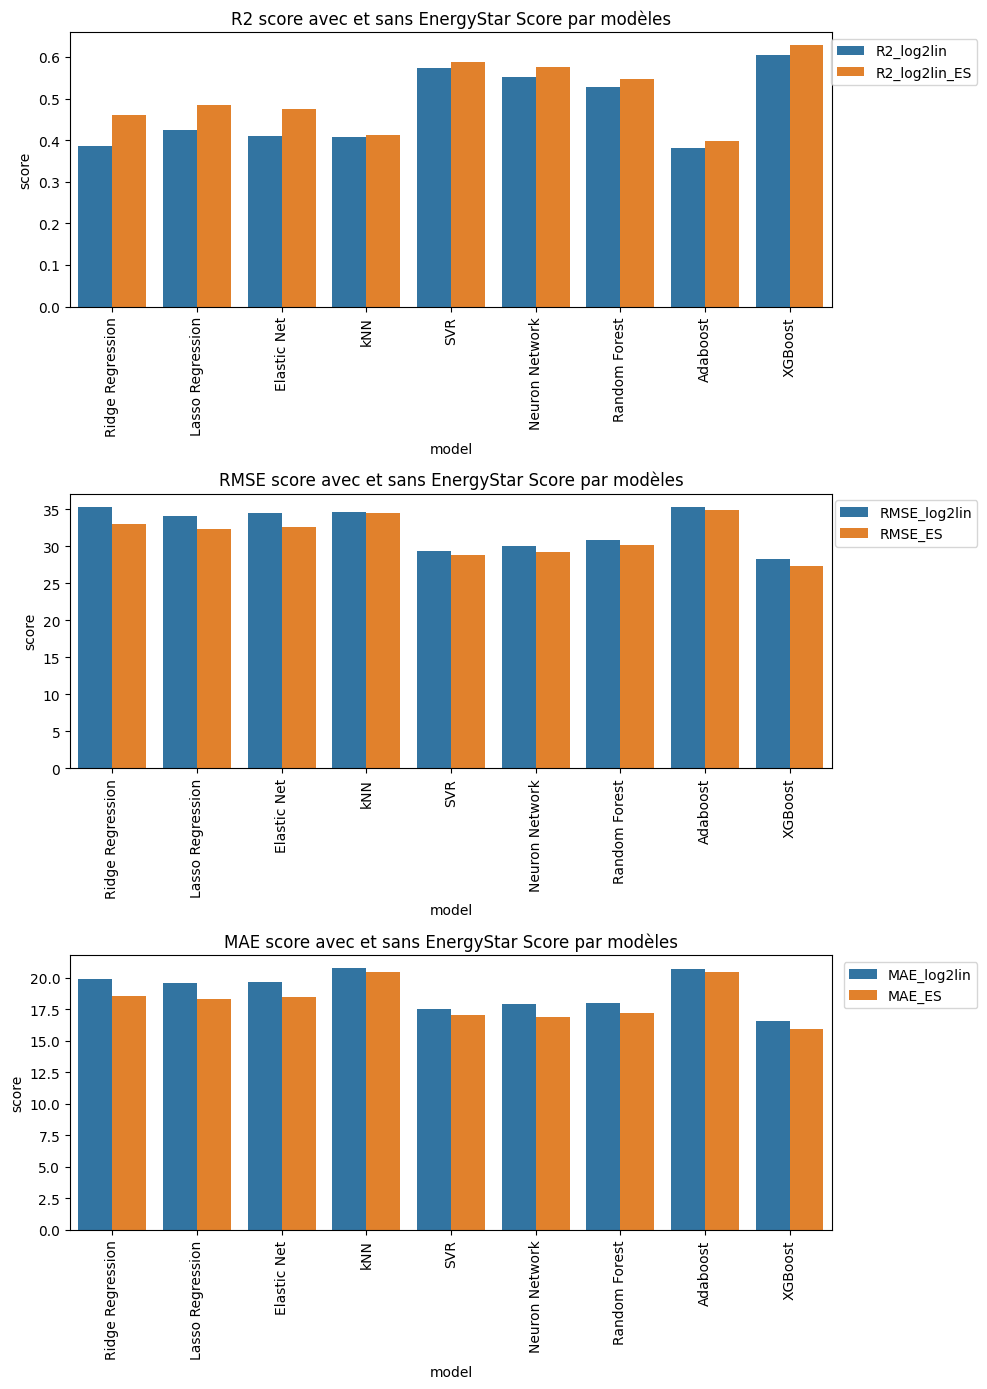

In [63]:
# Création de la figure et des sous-figures
fig, axs = plt.subplots(3, 1, figsize=(10, 14))

# Mise en forme du df avec les scores R2 par modèles
ES_compare_R2 = score.melt(id_vars=['model'], value_vars=['R2_log2lin', 'R2_log2lin_ES'], var_name='metric', value_name='score')

# Mise en forme du df avec les scores RMSE par modèles
ES_compare_RMSE = score.melt(id_vars=['model'], value_vars=['RMSE_log2lin', 'RMSE_ES'], var_name='metric', value_name='score')

# Mise en forme du df avec les scores MAE par modèles
ES_compare_MAE = score.melt(id_vars=['model'], value_vars=['MAE_log2lin', 'MAE_ES'], var_name='metric', value_name='score')

# Affichage des scores R2 en fonction du modèles avec et sans ES
sns.barplot(data=ES_compare_R2, x='model', y='score', hue='metric', ax=axs[0])
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90) # rotation de 90 degrés
axs[0].legend(bbox_to_anchor=(1.2, 1))
axs[0].title.set_text('R2 score avec et sans EnergyStar Score par modèles')

# Affichage des scores RMSE en fonction du modèles avec et sans ES
sns.barplot(data=ES_compare_RMSE, x='model', y='score', hue='metric', ax=axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90) # rotation de 90 degrés
axs[1].legend(bbox_to_anchor=(1.2, 1))
axs[1].title.set_text('RMSE score avec et sans EnergyStar Score par modèles')

# Affichage des scores MAE en fonction du modèles avec et sans ES
sns.barplot(data=ES_compare_MAE, x='model', y='score', hue='metric', ax=axs[2])
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=90) # rotation de 90 degrés
axs[2].legend(bbox_to_anchor=(1.2, 1))
axs[2].title.set_text('MAE score avec et sans EnergyStar Score par modèles')

fig.tight_layout()

# Comparaison XGBoost avec et sans ES

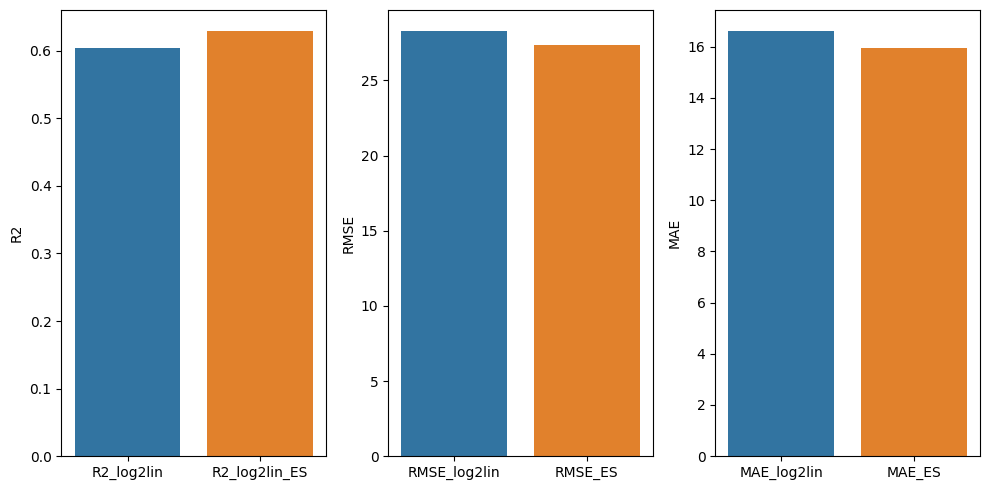

In [64]:

# Création de la figure et des sous-figures
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

# Barplot pour le score R2
sns.barplot(data=score.loc[score['model'] == 'XGBoost', ['R2_log2lin', 'R2_log2lin_ES']], ax=axs[0])
axs[0].set_ylabel('R2')
# Barplot pour le RMSE
sns.barplot(data=score.loc[score['model'] == 'XGBoost', ['RMSE_log2lin', 'RMSE_ES']], ax=axs[1])
axs[1].set_ylabel('RMSE')

# Barplot pour le MAE
sns.barplot(data=score.loc[score['model'] == 'XGBoost', ['MAE_log2lin', 'MAE_ES']], ax=axs[2])
axs[2].set_ylabel('MAE')

# Affichage de la figure
plt.tight_layout()
plt.show()

In [65]:
# Amélioration des score avec ES pour XGBoost

print('Amélioration R2 : +{} %'.format(round(((score.at[8, 'R2_cv_log_ES'] - score.at[8, 'R2_cv_log'] ) * 100),3)))
print('Amélioration RMSE : {} %'.format(round(((score.at[8, 'RMSE_ES'] - score.at[8, 'RMSE_log2lin']) / (score.at[8, 'RMSE_ES'] + score.at[8, 'RMSE_log2lin']) *100),4)))
print('Amélioration MAE : {} %'.format(round(((score.at[8, 'MAE_ES'] - score.at[8, 'MAE_log2lin']) / (score.at[8, 'MAE_ES'] + score.at[8, 'MAE_log2lin']) *100),4)))

Amélioration R2 : +2.7 %
Amélioration RMSE : -1.6081 %
Amélioration MAE : -1.965 %
